In [187]:
import os
import sys

sys.path.append("../PythonSIFT")
import pysift

import cv2 as cv

import matplotlib.pyplot as plt
import numpy as np

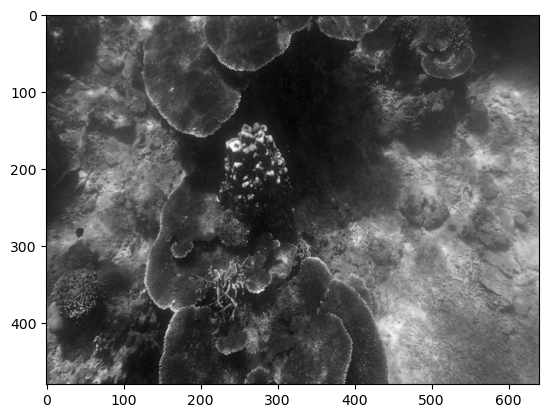

In [188]:
# load grayscale image
img = cv.imread("../images/87_img_.png", 0)

# cast and normalize image
# img = img.astype(np.float32)

# show image
plt.imshow(img, cmap="gray")

In [189]:
# calculate sift keypoints and descriptors
sift = cv.SIFT_create()
keypoints, descriptors = sift.detectAndCompute(img, None)

Number of keypoints:  1179


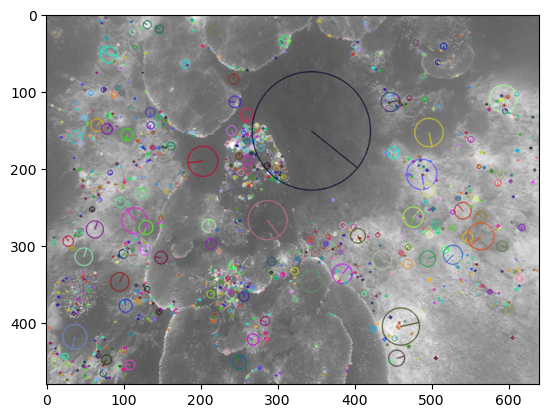

In [190]:
# draw keypoints
kp_img = cv.drawKeypoints(
    img, keypoints, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
)

# show image
plt.imshow(kp_img, cmap="gray")

# print number of keypoints
print("Number of keypoints: ", len(keypoints))

Calculate hessian of one keypoint


In [191]:
def compute_gradient(g_img, position):
    """
    Compute gradient with finite differences at order 1.
    g_img: grayscale image
    position: (y,x) position of point in pixels
    """
    y, x = position
    dx = g_img[y, x + 1] - g_img[y, x - 1]
    dy = g_img[y + 1, x] - g_img[y - 1, x]
    return np.array([dx, dy])


def compute_hessian(g_img, position):
    """
    Compute hessian with finite differences at order 2.
    g_img: grayscale image
    position: (y,x) position of the pixel
    """
    y, x = position
    # compute derivatives
    dxx = g_img[y, x + 1] + g_img[y, x - 1] - 2 * g_img[y, x]
    dyy = g_img[y + 1, x] + g_img[y - 1, x] - 2 * g_img[y, x]
    dxy = (
        g_img[y + 1, x + 1]
        + g_img[y - 1, x - 1]
        - g_img[y + 1, x - 1]
        - g_img[y - 1, x + 1]
    ) / 4
    return np.array([[dxx, dxy], [dxy, dyy]])

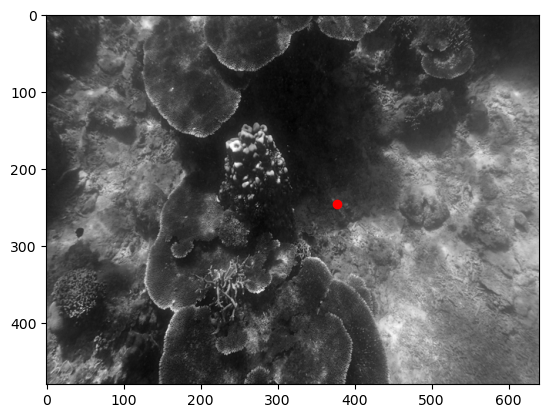

In [192]:
# compute gradient and hessian at one keypoint
kp0 = keypoints[555]
# load coordinates
y, x = kp0.pt
y = np.round(y).astype(int)
x = np.round(x).astype(int)

# show kp0 on image
plt.imshow(img, cmap="gray")
plt.scatter(x, y, c="r")
plt.show()

Gradient:  [254   3]
Hessian:  [[ 4.   63.25]
 [63.25  1.  ]]
Eigenvalues:  [ 65.76778406 -60.76778406]
Eigenvectors:  [[ 0.71543999 -0.69867419]
 [ 0.69867419  0.71543999]]


C:\Users\Jules\AppData\Local\Temp\ipykernel_20296\3555783048.py:8: RuntimeWarning: overflow encountered in scalar subtract
  dx = g_img[y, x + 1] - g_img[y, x - 1]
C:\Users\Jules\AppData\Local\Temp\ipykernel_20296\3555783048.py:24: RuntimeWarning: overflow encountered in scalar subtract
  g_img[y + 1, x + 1]


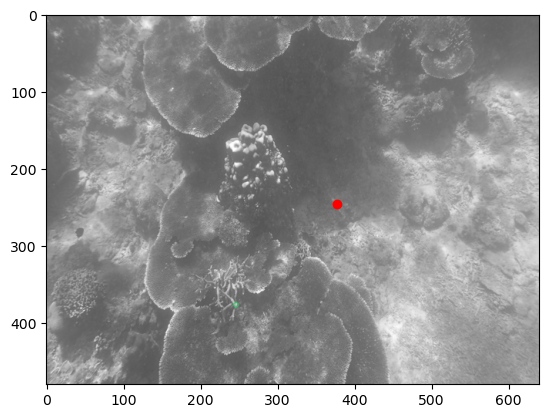

In [193]:
# show kp0 as keypoint
kp0_img = cv.drawKeypoints(img, [kp0], None)

# compute gradient and hessian of kp0 at scale 1
g = compute_gradient(img, (y, x))
H = compute_hessian(img, (y, x))

# print gradient and hessian
print("Gradient: ", g)
print("Hessian: ", H)

# compute eigenvalues and eigenvectors of H
eigvals, eigvecs = np.linalg.eig(H)

# print eigenvalues and eigenvectors
print("Eigenvalues: ", eigvals)
print("Eigenvectors: ", eigvecs)

# draw eigenvectors at kp0
plt.imshow(kp0_img, cmap="gray")
plt.scatter(x, y, c="r")
plt.show()

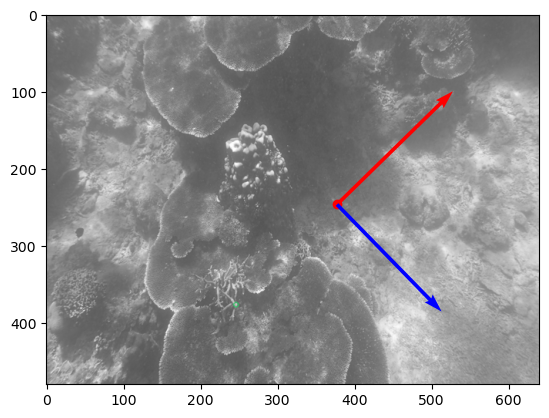

In [194]:
# Create position vectors that match the size of the eigenvectors
x_positions = np.full(eigvecs.shape[1], x)
y_positions = np.full(eigvecs.shape[1], y)

# normalize eigenvectors and multiply each by absolute eigenvalue
scaled_eigvecs = eigvecs / np.linalg.norm(eigvecs, axis=0) * eigvals

# Define a scaling factor
scaling_factor = 0.5  # Adjust this value as needed

# Scale the eigenvectors
scaled_eigvecs = scaled_eigvecs * scaling_factor

# draw eigenvectors at kp0
plt.imshow(kp0_img, cmap="gray")
plt.scatter(x, y, c="r")

plt.quiver(
    x_positions,
    y_positions,
    scaled_eigvecs[0, :],
    scaled_eigvecs[1, :],
    color=["r", "b"],
    scale=100,
)

plt.show()

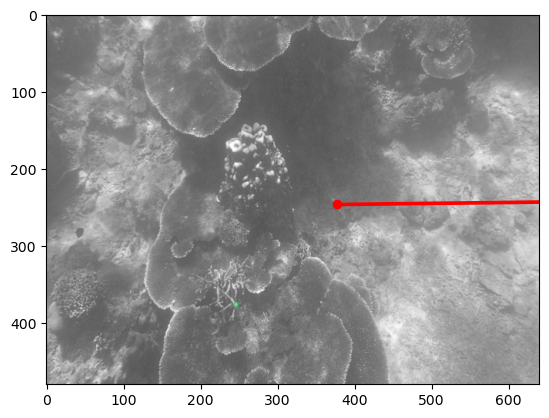

In [195]:
# draw gradient at kp0
plt.imshow(kp0_img, cmap="gray")
plt.scatter(x, y, c="r")
plt.quiver(x, y, g[0], g[1], color="r", scale=100)
plt.show()

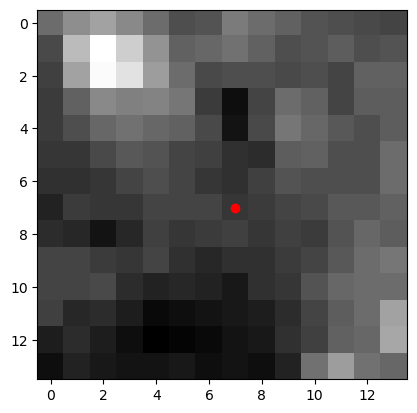

In [196]:
# zoom in on kp0 in a square of adjustable size
radius = 7
sub_img = img[y - radius : y + radius, x - radius : x + radius]
plt.imshow(sub_img, cmap="gray")
# scatter plot centered in the sub-image
plt.scatter(radius, radius, c="r")
plt.show()

C:\Users\Jules\AppData\Local\Temp\ipykernel_20296\3555783048.py:21: RuntimeWarning: overflow encountered in scalar add
  dxx = g_img[y, x + 1] + g_img[y, x - 1] - 2 * g_img[y, x]
C:\Users\Jules\AppData\Local\Temp\ipykernel_20296\3555783048.py:22: RuntimeWarning: overflow encountered in scalar add
  dyy = g_img[y + 1, x] + g_img[y - 1, x] - 2 * g_img[y, x]
C:\Users\Jules\AppData\Local\Temp\ipykernel_20296\3555783048.py:24: RuntimeWarning: overflow encountered in scalar add
  g_img[y + 1, x + 1]
C:\Users\Jules\AppData\Local\Temp\ipykernel_20296\3555783048.py:24: RuntimeWarning: overflow encountered in scalar subtract
  g_img[y + 1, x + 1]


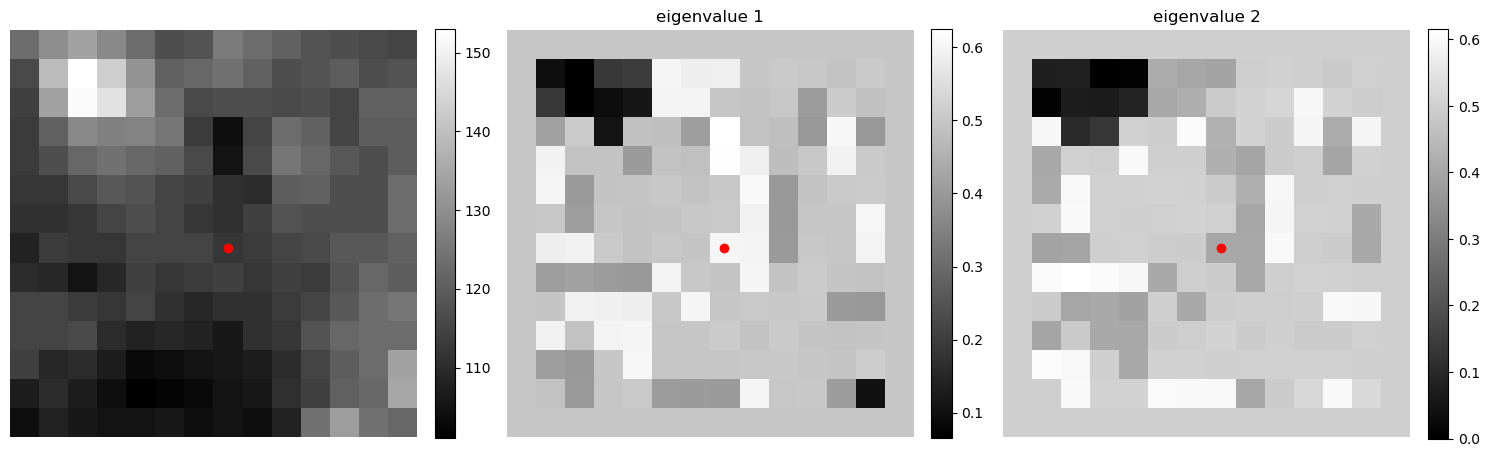

In [198]:
# Compute hessian eigenvalues of all pixels in subimage, (excluding a pixel border).
border_size = 1
h, w = sub_img.shape
eigvals = np.zeros((h, w, 2), dtype=np.float32)
for y in range(border_size, h - border_size):
    for x in range(border_size, w - border_size):
        H = compute_hessian(sub_img, (y, x))
        eigvals[y, x] = np.linalg.eigvals(H)

# Normalize eigenvalues with the max absolute value
normalized_eigvals = eigvals / np.max(np.abs(eigvals))

# Compute colormap images
eigvals1 = normalized_eigvals[:, :, 0]
eigvals2 = normalized_eigvals[:, :, 1]

# Affine transform eigenvalues from [-1,1] to [0, 1]
eigvals1 = (eigvals1 + 1) / 2
eigvals2 = (eigvals2 + 1) / 2

# Plot subimage and eigenvalues
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot subimage
im0 = axs[0].imshow(sub_img, cmap="gray")
axs[0].axis("off")
# add red pixel on the keypoint
axs[0].scatter([radius], [radius], c="r")

# Plot colormap images
im1 = axs[1].imshow(eigvals1, cmap="gray")
axs[1].set_title("eigenvalue 1")
axs[1].axis("off")
# add red pixel on the keypoint
axs[1].scatter([radius], [radius], c="r")
# # Add red pixel on the left vertical border at the same y as keypoint
# axs[1].scatter([0], [radius], c="r")
# # Add red pixel on the bottom horizontal border at the same x as keypoint
# axs[1].scatter([radius], [sub_img.shape[0] - 1], c="r")

im2 = axs[2].imshow(eigvals2, cmap="gray")
axs[2].set_title("eigenvalue 2")
axs[2].axis("off")
# add red pixel on the keypoint
axs[2].scatter([radius], [radius], c="r")
# # Add red pixel on the left vertical border at the same y as keypoint
# axs[2].scatter([0], [radius], c="r")
# # Add red pixel on the bottom horizontal border at the same x as keypoint
# axs[2].scatter([radius], [sub_img.shape[0] - 1], c="r")

# Add colorbar and adjust its size so it matches the images
fig.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)
fig.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)
fig.colorbar(im2, ax=axs[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

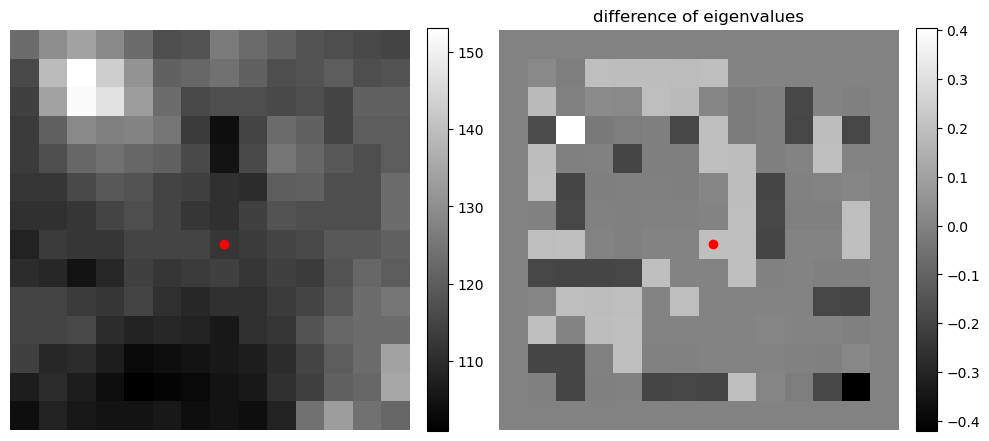

In [200]:
# plot subimage and difference of eigenvalues
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot subimage
im0 = axs[0].imshow(sub_img, cmap="gray")
axs[0].axis("off")
axs[0].scatter([radius], [radius], c="r")

# Plot difference of eigenvalues
im1 = axs[1].imshow(eigvals1 - eigvals2, cmap="gray")
axs[1].set_title("difference of eigenvalues")
axs[1].axis("off")
# add red pixel on the keypoint
axs[1].scatter([radius], [radius], c="r")
# # Add red pixel on the left vertical border at the same y as keypoint
# axs[1].scatter([0], [radius], c="r")
# # Add red pixel on the bottom horizontal border at the same x as keypoint
# axs[1].scatter([radius], [sub_img.shape[0] - 1], c="r")

# Add colorbar and adjust its size so it matches the images
fig.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)
fig.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

Calculate eigenvalues of all keypoints


In [159]:
# calculate eigenvalues of hessian for all keypoints, except a 5 pixel border
border_size = 5

# initialize array of eigenvalues at -1. (for border pixels)
eigvals = np.full((len(keypoints), 2), fill_value=-1.0, dtype=np.float32)

for i, kp in enumerate(keypoints):
    # load coordinates
    y, x = kp.pt
    y = np.round(y).astype(int)
    x = np.round(x).astype(int)
    # skip keypoints that are too close to the border
    if y < border_size or y > img.shape[0] - border_size:
        continue

    # compute hessian
    H = compute_hessian(img, (y, x))
    # compute eigenvalues
    eigvals[i] = np.linalg.eigvals(H)

eigvals[:50]

C:\Users\Jules\AppData\Local\Temp\ipykernel_20296\3555783048.py:24: RuntimeWarning: overflow encountered in scalar subtract
  g_img[y + 1, x + 1]
C:\Users\Jules\AppData\Local\Temp\ipykernel_20296\3555783048.py:21: RuntimeWarning: overflow encountered in scalar add
  dxx = g_img[y, x + 1] + g_img[y, x - 1] - 2 * g_img[y, x]
C:\Users\Jules\AppData\Local\Temp\ipykernel_20296\3555783048.py:22: RuntimeWarning: overflow encountered in scalar add
  dyy = g_img[y + 1, x] + g_img[y - 1, x] - 2 * g_img[y, x]
C:\Users\Jules\AppData\Local\Temp\ipykernel_20296\3555783048.py:24: RuntimeWarning: overflow encountered in scalar add
  g_img[y + 1, x + 1]


array([[  -1.        ,   -1.        ],
       [  20.204163  ,   14.795836  ],
       [  67.7558    ,  -50.755802  ],
       [-244.98444   , -249.01556   ],
       [  59.        ,  -65.        ],
       [  59.        ,  -65.        ],
       [  64.75      ,  -62.75      ],
       [   6.        ,    0.        ],
       [   6.        ,    0.        ],
       [ -67.008064  ,   57.008064  ],
       [ -58.002033  ,   65.00203   ],
       [  56.785862  ,  -54.785862  ],
       [  56.785862  ,  -54.785862  ],
       [-325.3323    , -216.6677    ],
       [  -2.25      ,   -3.75      ],
       [  -2.25      ,   -3.75      ],
       [   0.5       ,   -0.5       ],
       [ -18.010412  ,    6.010412  ],
       [ -18.010412  ,    6.010412  ],
       [ -18.010412  ,    6.010412  ],
       [  10.095674  ,   30.904325  ],
       [ -63.532513  ,   59.532513  ],
       [  53.508263  ,  -67.50826   ],
       [  -3.1189563 ,  -10.881043  ],
       [  -2.0495098 ,    3.0495098 ],
       [  60.945778  ,  -

In [ ]:
# normalize eigenvalues with the max absolute value
normalized_eigvals = eigvals / np.max(np.abs(eigvals))

# compute colormap images